<span style="font-size:2em">Comparison of autoencoders and classical methods to impute missing values for continuous variables</span> 

**François Husson, Professor in Statistics, Rennes**

The purpose of this notebook is to compare in terms of imputation different autoencoders: 
    
* **MIDA**, a denoising autoencoder proposed by Lovedeep Gondara ande Wang (2018) in [MIDA : Multiple Imputation using Denoising Autoencoders](https://arxiv.org/abs/1705.02737),

* **SDAi**, a denoising autoencoder proposed by Abiri et al. (2019) in [Establishing strong imputation performance of a denoising autoencoder in a wide range of missing data problems](https://arxiv.org/abs/2004.02584),

* **MIWAE**, a variational autoencoder proposed by Mattei et Frellsen (2019) in  [MIWAE : Deep Generative Modelling and Imputation of Incomplete Data Sets](https://arxiv.org/abs/1812.02633),

* **ImputePCA**, function from the [R package missMDA](https://www.jstatsoft.org/article/view/v070i01), viewed as a linear autoencoder

to the classical methods of imputation:
    
* **RandomForest**, iterative imputation using an estimator based on random forests from [sklearn.impute](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html).

* **Mean**, the naive imputation by the mean. 
    
This notebook is composed of 4 parts:
<ol>
<li>Install and load the packages.</li>
<li>Create the files with the missing values.</li>
<li>Automatic optimization of algorithms and performance evaluation.</li>
<li>Creation of the synthesis files and plot of the results.</li> 


# Install and load the packages

This notebook contains both Python and R code. Installing tensorflow and torch can be difficult, as can installing missMDA in R, please follow these instructions.

The right environment with all the packages installed is available [here]():
download the file and in a terminal do: **conda env create -f deep-husson-env.yml**.

Then, 

* Install ipykernel

* Activate a kernel related to our environment: **python -m ipykernel install --user --name=deep-husson-env**

* Launch jupyter notebook (in the terminal)

* Choose the kernel deep-husson-env



If you do not want to use the available environment, in a terminal:

* Create a new environment: **conda create --name deep-husson-env**

* Activate the new environment: **conda activate deep-husson-env**

* Install packages python (e.g. tensorflow, torch, pandas, scikit-learn, rpy2): use conda install (lines of code available [here](https://anaconda.org/conda-forge/repo)), pip install should be used as a last resort

* In a R session (in the terminal), install missMDA: **install.packages(‘missMDA’)**

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.impute import SimpleImputer

import torch
import torchvision
import torch.nn as nn
import scipy.stats
import scipy.io
import scipy.sparse
from scipy.io import loadmat
import torch.distributions as td

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

device = torch.device("cpu")

/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

In [2]:
# Load the extension of python to use R.
%load_ext rpy2.ipython

/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
# Packages to load in R
%R library(missMDA)
%R library(mvtnorm)

array(['mvtnorm', 'missMDA', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [4]:
#To check if all the needed packages are in your R session. 
#%%R
#sessionInfo()

In [5]:
from Deep_Notebook_introduceNA import *

In [6]:
from Deep_Notebook_methods import *

# Create the datasets with missing values


## Create a complete dataset 

First, we choose the proportion of the dataset for validation, a vector for the percentages of missing values to be tested and the number of version created for each percentage of missing values. 

In [7]:
## Parameters
valid_size = 0.3 #Proportion of the dataset for validation
t = [0.1,0.2,0.3] # Percentage of NA
version = 10 # Number of versions created for each percentage of NA

#DO NOT MODIFY
NA = [str(int(k*100)) for k in t] # Percentage of NA as a character string

### Complete dataset in R

In this part, a complete dataset $X \in \mathbb{R}^{n\times d}$ is generated. Different models can be chosen: 

* **linear relation** between the covariates. More particularly, 

    * we generate $(x_1,x_2) \sim \mathcal{N}(\mu,\Sigma)$, with $x_1,x_2 \in \mathbb{R}^n$.
    * $X = [x_1,\dots,x_1,x_2,\dots,x_2] + \epsilon,$ with $\epsilon \sim \mathcal{N}(0,\sigma^2 I_{d\times d})$. The $k$ first columns are $x_1+\mathrm{noise}$ and the $d-kd$ last columns are $x_2+\mathrm{noise}$.
    
* **non-linear relation** between the covariates. 

    * $\forall j \in \{1,\dots,d\}$, the column $j$ of $X$ is such that $X_{.j}=\sin\left(f_n\left(2\pi\frac{(j-1)}{d} + u_n\right)\right)+\epsilon_{.j}$,
    with $u_n \sim \mathcal{U}[0;2\pi]$ (uniform law) and $f_n$ is fixed and chosen by the user.
    
The function in R **create_complete_dataset** allows to create a complete dataset $X$ in such ways. The arguments are detailed as follows
* `seed`: seed to reproduct the simulations.

* `n`: number of observations in $X$.

* `d`: number of covariates in $X$. 

* `noise`: variance of the noise $\epsilon$.

* `modSimu`: "linear" or "non-linear".

* `k`: if `modSimu="linear"`, it indicates how much colomns are equal to $x_1$ and $x_2$. 

* `mu`: if `modSimu="linear"`, the mean vector of $(x_1,x_2)$.

* `Sigma`: if `modSimu="linear"`, the covariance matrix of $(x_1,x_2)$.

* `fn`: if `modSimu="non-linear"`, the scale-parameter to use.

In [8]:
%%R
create_complete_dataset <- function(seed,nind,d,noise,modSimu,k=NULL,mu=NULL,Sigma=NULL,fn=NULL){
    if (modSimu == "linear"){
      X <- rmvnorm(nind, mu.X, Sigma.X)
      X <- X[,c(rep(1,round(d*k)),rep(2,d-round(d*k)))]
      X <- X + matrix(rnorm(nind*d,0,noise),ncol=d)
      tab <- X
    }
    if (modSimu == "non-linear"){
      un <-  runif(nind,0,2*pi)
      tab <- matrix(NA,nind,d)
      for (j in 1:d) tab[,j]= sin(fn * (2 * pi * (j-1)/d + un)) +rnorm(nind,0,noise)
    }
    return(tab)
}

The path indicates where the dataset is located and where files with missing values will be created.
Think about adapting the way of uploading the dataset (pd.read_csv, pd.read_table...)

In [9]:
#Directory for data and results
path = './'

np.random.seed(641)
tf.random.set_random_seed(641)

In [10]:
%%R
seed <- 6451
nind <- 300
noise <- 0.1
d <- 5
#k <- 0.6
#mu <- c(1, 1)
#Sigma <- matrix(c(1, 1, 1, 4), nrow = 2)
modSimu <- "non-linear"
fn <- c(rep(1,d))

tab <- create_complete_dataset(seed,nind,d,noise,modSimu,fn=fn)

### Take the same dataset in Python

In [11]:
tab_p = %R tab
data = pd.DataFrame(tab_p)
column = data.columns
nind_p = %R nind
noise_p = %R noise
d_p = %R d
nom_data = 'simu_nind{0}_noise{1}_d{2}'.format(int(nind_p[0]),int(100*noise_p[0]),int(d_p[0]))

### Split the dataset in training and test dataset

In [12]:
rows, cols = data.shape
shuffled_index = np.random.permutation(rows)
train_index = shuffled_index[:int(rows*(1-valid_size))]
valid_index = shuffled_index[int(rows*(1-valid_size)):]

train_data = data.iloc[train_index, :]
valid_data = data.iloc[valid_index, :]

### Standardization of the variables with MinMaxScaler

In [13]:
#Standardization of the variables
scaler = MinMaxScaler()
scaler.fit(train_data)
X_t = scaler.transform(train_data)
X_v = scaler.transform(valid_data)
X_train = pd.DataFrame(scaler.transform(train_data))
X_train.columns = column
X_Valid = pd.DataFrame(scaler.transform(valid_data))
X_Valid.columns = column

### Export the train and test dataset

In [14]:
X_train.to_csv(path+'X_train.csv', index = True)
X_Valid.to_csv(path+'X_Valid.csv', index = True)

## Introduce missing values

To introduce missing values, we use the function **missing_method** of the MIDA's [article](https://arxiv.org/abs/1705.02737) to add missing values with MCAR or MAR mechanism, when the unaivability of the data does not depend on the data values (MCAR) or depends on the values of the observed variables (MAR).

The function **missing_method** has the following arguments:

* `raw_data`: complete dataset.

* `mechanism`: type of the process which causes the lack of data: "mcar" or "mar".

* `method`: ...

* `t`: percentage of missing values to introduce.

### Creation and export of the files with the datasets and the associates masks

Missing values are imputed by the mean as an initialization step of the algorithms.

In [15]:
z = 0
mecha = 'mcar'
for prop_NA in t:
    for i in range(1,version+1,1):
        # Add missing values

        missed_data, mask = missing_method(X_train, mechanism=mecha, method='uniform', t = prop_NA)
        mask = np.invert(mask)

        missed_valid, mask_valid = missing_method(X_Valid, mechanism=mecha, method='uniform', t = prop_NA)
        mask_valid = np.invert(mask_valid)

        # Impute by the mean

        missed_data = imput_mean(missed_data,mask)
        missed_valid = imput_mean(missed_valid,mask_valid)    

        # Export as csv
        missed_data.to_csv(path+'missed_data_{0}_v{1}.csv'.format(NA[z], i), index = True)
        mask_export = pd.DataFrame(mask)
        mask_export.to_csv(path+'mask_{0}_v{1}.csv'.format(NA[z], i), index = False)    
        mask_export = pd.DataFrame(mask_valid)
        mask_export.to_csv(path+'mask_valid_{0}_v{1}.csv'.format(NA[z], i), index = False)
        missed_valid.to_csv(path+'missed_valid_{0}_v{1}.csv'.format(NA[z], i), index = True)
        
    z += 1


# Automatic optimization of algorithms and performance evaluation

In this part the algorithms are optimized. We test for the different autoencoders various structures (more or less layers, more or less nodes and 2 types of activation functions for MIDA, SDAI pt and SDAI spt) and for RandomForest various numbers of trees and different levels of depth.

## Parameters

If this part is executed independently of the previous one, please remove the '#' from the next cell and fill in the fields.


In [16]:
versions = [k for k in range(1,version+1)]

### Number of times for which a same combination is evaluated.
rep = 1 

###Tested algorithms
###Names of the algorithms: 
#       - MIWAE
#       - MIDA 
#       - SDAI spt/pt: without pre-training (spt) or with (pt)
#       - RF : RandomForest
#       - mean 
#article = ['MIDA','SDAI pt','SDAI spt','MIWAE','RF','mean'] 
article = ['mean','MIWAE','RF'] 


#Number of variables in the dataset 
#(useful to create the layers in autoencoders)

columns_name = pd.read_csv(path+'X_train.csv'.format(NA), sep =',')
columns_name = columns_name.columns

nb_var = len(columns_name)-1

#### Parameters for MIWAE (Variational AutoEncoder)

In [17]:
### Size of the bachs
bs  = 50

### Number of epochs
n_epochs = 50

### Dimension of the latent space
dim_lat = 10  

### Number of IS during the training
K = 20 

### Number of units for each layer (this number is the same for all layers). 
### Encoder and decoder are multi-layer perceptrons with 3 hidden layers
units=[128] 

#### Parameters for MIDA, SDAI pt/spt (Denoising AutoEncoders)

In [18]:
###Size of the bachs
batch_size = 32

###Number of epochs for the pre training
num_epochs_pt = 10 

###Number of epochs for the fine tuning
num_epochs_ft = 40 

###Structures evaluated for each autoencoder. 
#Ex for MIDA: [15,20] = input layer -> encoder with 15 units -> latent layer with 20 units -> decoder with 15 units -> output layer

layers = {'MIDA':[[25, 30], [25, 35], [25, 40], [25, 28, 30], [25, 30, 35],
       [25, 30, 40], [25, 30, 45], [25, 30, 35, 40]],
      # [25, 30, 40, 50]],
          'SDAI spt':[[18, 14], [18, 10], [18, 8], [18, 16, 14], [18, 12, 6],
       [18, 14, 10, 6]],
          'SDAI pt':[[18, 14], [18, 10], [18, 8], [18, 16, 14], [18, 12, 6],
       [18, 14, 10, 6]],
}


### Activated function
activ = ['relu','tanh']

### Activated function for the layer output
output_activ = 'sigmoid' 

### Rate of cut pathways 
dropout_rate = 0.5 

###Optimizer
opt = tf.keras.optimizers.Adam(0.01)


## Creation of output files with the results

We now create output files with the results of the algorithms.

The following informations are available:
* **Algorithm** : name of the algorithm 
* **Percent_NA** : percentage of missing values
* **Version** : number of version for a same percentage of missing values  
* **Layers** : structure of the algorithm 
* **Activation** : activated function for the internal layers 
* **RMSE** : RMSE 
* **Loss** : list with the mean value of the loss function for each (on the train dataset) 
* **Validation_loss** :  list with the mean value of the loss function for each epoch (on the test dataset) 
<font color=red>ATTENTION: the following lines of code erase the file if it already exists</font>

In [19]:
with open(path + 'Results_{}.csv'.format(nom_data), 'w', newline='') as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(['Algorithm','Percent_NA','Version','Layers','Activation','RMSE','Loss','Validation_loss'])

### Comparison of the algorithms

Here, for each algorithm, each percentage of missing values and each file version for a percentage of missing values, all architecture(number of layers and nodes)/activation function combinations are searched for, whereby only ReLU is tested for MIWAE. The previously created csv file compiles the results (=RMSE) obtained from the test files. 

#### Methods in Python

In [20]:
for art in article: 
    for val in NA:
        for vers in versions:   
                  
            mask = pd.read_csv(path+'mask_{0}_v{1}.csv'.format(val,vers))
            mask = np.array(mask)
            
            missed_data = pd.read_csv(path+'missed_data_{0}_v{1}.csv'.format(val,vers), index_col = 0)
            missed_data = np.array(missed_data)    
            xhat_0 = np.copy(missed_data)
            n = missed_data.shape[0]
            
            mask_valid = pd.read_csv(path+'mask_valid_{0}_v{1}.csv'.format(val,vers))
            mask_valid = np.array(mask_valid)
            
            missed_valid = pd.read_csv(path+'missed_valid_{0}_v{1}.csv'.format(val,vers), index_col = 0)
            missed_valid = np.array(missed_valid)
            
            X_valid = pd.read_csv(path+'X_valid.csv', index_col = 0)
            X_valid = np.array(X_valid)
            
            X_train = pd.read_csv(path+'X_train.csv', index_col = 0)
            X_train = np.array(X_train)
                  
            if art not in ['mean','RF','MIWAE']:
                ###Management of data for the denoising autoencoders 
                
                #####################################Dataset with NA tensorflow
                miss_dataset = tf.data.experimental.make_csv_dataset(
                        path+'missed_data_{}_v{}.csv'.format(val,vers),
                        batch_size,
                        column_names=columns_name,
                        label_name='Unnamed: 0',
                        shuffle = False,
                        num_epochs=1)
                
                miss_dataset = miss_dataset.map(pack_features_vector)
                features_miss, labels_miss = next(iter(miss_dataset))
                
                #####################################Reference dataset tensorflow
                train_dataset = tf.data.experimental.make_csv_dataset(
                        path+'X_train.csv',
                        batch_size,
                        column_names=columns_name,
                        label_name='Unnamed: 0',
                        shuffle = False,
                        num_epochs=1)
                
                train_dataset = train_dataset.map(pack_features_vector)
                features_train, labels_train = next(iter(train_dataset))
                
                #####################################Dataset valid tensorflow
                if int(mask.shape[0]/batch_size)==mask.shape[0]/batch_size:
                    num_b = int(mask.shape[0]/batch_size)
                else:
                    num_b = int(mask.shape[0]/batch_size) + 1
                    
                valid_dataset = tf.data.experimental.make_csv_dataset(
                        path+'X_Valid.csv',
                        num_b,
                        column_names=columns_name,
                        label_name='Unnamed: 0',
                        shuffle = False,
                        num_epochs=1)
                
                valid_dataset = valid_dataset.map(pack_features_vector)
                features_valid, labels_valid = next(iter(valid_dataset))
            
            
                for layers_dense in layers[art]:
                    print('###################################Percentage NA:',val)
                    print('###################################Version:',vers)
                    print('###################################Layers:',layers_dense)
                    for factiv in activ:
                        for repet in range(rep):
                            if art == 'SDAI pt' :
                                ###el for the encoder layers and dl for the decoder layers
                                el, dl, dense = pre_training(missed_data, X_valid, num_epochs_pt, output_activ, layers_dense, factiv, miss_dataset, valid_dataset, batch_size, opt, mask)
                                NaN_sdae = keras.models.Sequential()
                                NaN_sdae.add(keras.layers.Input(shape=[nb_var]))
                                for k in range(0,len(dense),1):
                                    NaN_sdae.add(keras.layers.Dropout(dropout_rate))
                                    NaN_sdae.add(el[k])
                                for k in range(0,len(dense),1):
                                    ind = k + 1
                                    NaN_sdae.add(dl[-ind])
                                
                            elif art == 'SDAI spt' :
                                dense = layers_AE(layers_dense, factiv)
                                NaN_sdae = keras.models.Sequential()
                                NaN_sdae.add(keras.layers.Input(shape=[nb_var]))
                                for k in range(0,len(dense),1):
                                    NaN_sdae.add(keras.layers.Dropout(dropout_rate))
                                    NaN_sdae.add(dense[k])
                                for k in range(0,len(dense),1):
                                    ind = k+ 1
                                    if ind != len(dense):
                                        NaN_sdae.add(DenseTranspose(dense[-ind], activation = factiv))
                                    else:
                                        NaN_sdae.add(DenseTranspose(dense[-ind], activation = output_activ))
                            
                            elif art == 'MIDA' :
                                NaN_sdae = keras.models.Sequential()
                                NaN_sdae.add(keras.layers.Input(shape=[nb_var]))
                                for k in range(0,len(layers_dense),1):
                                    NaN_sdae.add(keras.layers.Dropout(dropout_rate))
                                    NaN_sdae.add(keras.layers.Dense(layers_dense[k], activation = factiv))
                                for k in range(0,len(layers_dense)-1,1):
                                    ind = k + 2
                                    NaN_sdae.add(keras.layers.Dense(layers_dense[-ind], activation = factiv))
                                NaN_sdae.add(keras.layers.Dense(nb_var, activation = output_activ))
                            
                            history = train_all(NaN_sdae, num_epochs_ft, opt, mask, miss_dataset, valid_dataset, batch_size) 
                            predictions = NaN_sdae(np.array(missed_valid)).numpy()           

                            ### RMSE 
                            mask_NA = np.invert(mask_valid)
                            data = missed_valid.copy()
                            data[mask_NA] = predictions[mask_NA]
                            ref = np.array(X_valid)
                            RMSE = np.sqrt(np.mean(np.square((ref[mask_NA]-predictions[mask_NA]))))		
                            print('RMSE: ', RMSE)
                            
                            #write the results in the csv file
                            with open(path + 'Results_{0}.csv'.format(nom_data), 'a', newline='') as file:
                                writer = csv.writer(file, delimiter = ';')
                                writer.writerow([art,val,vers,layers_dense,factiv,RMSE,history[0],history[1]])
            elif art == 'MIWAE':
                for h in units:
                    for repet in range(rep):
                        print('###################################Percentage of NA:',val)
                        print('###################################Version:',vers)
                        print('###################################Value of the hidden units:',h)

                        ### Prior Gaussien 
                        p_z = td.Independent(td.Normal(loc=torch.zeros(dim_lat).to(device),scale=torch.ones(dim_lat).to(device)),1)

                        ### 'ReLU' can be replaced by 'Tanh'
                        encoder = nn.Sequential(
                            torch.nn.Linear(nb_var, h),
                            torch.nn.ReLU(),
                            torch.nn.Linear(h, h),
                            torch.nn.ReLU(),
                            torch.nn.Linear(h, 2*dim_lat),  
                        )

                        ### the decoder gives the mean, the scale and the degree of freedom
                        decoder = nn.Sequential(
                            torch.nn.Linear(dim_lat, h),
                            torch.nn.ReLU(),
                            torch.nn.Linear(h, h),
                            torch.nn.ReLU(),
                            torch.nn.Linear(h, 3*nb_var),  
                        )

                        miwae_loss_train=np.array([])
                        rmse_train=np.array([])

                        # Matrix of the imputed/generated data
                        xhat = np.copy(xhat_0) 

                        encoder.apply(weights_init)
                        decoder.apply(weights_init)

                        ###Optimizer
                        optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=1e-3)

                        loss_train = []

                        for ep in range(1,n_epochs):
                            perm = np.random.permutation(n) 
                            batches_data = np.array_split(xhat_0[perm,], n/bs)
                            batches_mask = np.array_split(mask[perm,], n/bs)
                            for it in range(len(batches_data)):
                                optimizer.zero_grad()
                                encoder.zero_grad()
                                decoder.zero_grad()
                                b_data = torch.from_numpy(batches_data[it]).float().to(device)
                                b_mask = torch.from_numpy(batches_mask[it]).float().to(device)
                                loss = miwae_loss(iota_x = b_data,mask = b_mask, d = dim_lat, K = K, p_z = p_z, encoder = encoder, decoder = decoder)
                                loss_train.append(loss)
                                loss.backward()
                                optimizer.step()

                        ### Impute the values  
                        missed_valid[~mask_valid] = miwae_impute(iota_x = torch.from_numpy(missed_valid).float().to(device),mask = torch.from_numpy(mask_valid).float().to(device),L=10, d = dim_lat, p_z = p_z, encoder = encoder, decoder = decoder).cpu().data.numpy()[~mask_valid]
                        err = np.array([rmse(missed_valid,X_valid,mask_valid)])
                        print('RMSE : %g' %err)
                        with open(path + 'Results_{0}.csv'.format(nom_data), 'a', newline='') as file:
                            writer = csv.writer(file, delimiter = ';')
                            writer.writerow([art,val,vers,[h]*3,'ReLU',err[0],loss_train,'--'])
                
            else:
                print('###################################Percentage NA:',val)
                print('###################################Version:',vers)
                layers_dense = '--'
                factiv = '--'
                history = ['--','--']
                if art == 'RF':
#                            parameters = {'n_estimators':[30], 'max_depth': [7]}
#                            parameters = {'n_estimators':[5,10,20,30,40,50], 'max_depth': [1,3,5,7,9]}
                            parameters = {'n_estimators':[5,10], 'max_depth': [1,3,5]}
                            perf = []
                            param = []
                            mask_NA = np.invert(mask)
                            missed_data[mask_NA] = np.nan
                            for A in parameters['n_estimators']:
                                for B in parameters['max_depth']:
                                    missRF = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators = A, max_depth = B))
                                    missRF.fit(missed_data)
                                    res = missRF.transform(missed_data)
                                    data = missed_data.copy()
                                    data[mask_NA] = res[mask_NA]
                                    ref = np.array(X_train)
                                    rmse = np.sqrt(np.mean(np.square((ref[mask_NA]-res[mask_NA]))))
                                    perf.append(rmse)
                                    param.append([A,B])
                            RFimput = IterativeImputer(random_state=0, estimator=ExtraTreesRegressor(n_estimators = param[np.argmin(perf)][0], max_depth = param[np.argmin(perf)][1]))
                            RFimput.fit(missed_data)
                            test = missed_valid.copy()
                            mask_NA = np.invert(mask_valid)
                            test[mask_NA] = np.nan
                            predictions = RFimput.transform(test)
                        
                elif art == 'mean':
                    predictions = missed_valid
                             
                ### RMSE 
                mask_NA = np.invert(mask_valid)
                data = missed_valid.copy()
                data[mask_NA] = predictions[mask_NA]
                ref = np.array(X_valid)
                RMSE = np.sqrt(np.mean(np.square((ref[mask_NA]-predictions[mask_NA]))))
                print('RMSE: ', RMSE)
                
                #Write the results in a csv file
                with open(path + 'Results_{0}.csv'.format(nom_data), 'a', newline='') as file:
                    writer = csv.writer(file,delimiter=';')
                    writer.writerow([art,val,vers,layers_dense,factiv,RMSE,history[0],history[1]])


###################################Percentage NA: 10
###################################Version: 1
RMSE:  0.30723937544760627
###################################Percentage NA: 10
###################################Version: 2
RMSE:  0.28559567284914655
###################################Percentage NA: 10
###################################Version: 3
RMSE:  0.29767329797064307
###################################Percentage NA: 10
###################################Version: 4
RMSE:  0.2806313687607458
###################################Percentage NA: 10
###################################Version: 5
RMSE:  0.2662073220611853
###################################Percentage NA: 10
###################################Version: 6
RMSE:  0.2889227048992675
###################################Percentage NA: 10
###################################Version: 7
RMSE:  0.29136875139142615
###################################Percentage NA: 10
###################################Version: 8
RMSE:  0.3071529870025

RMSE : 0.162148
###################################Percentage of NA: 30
###################################Version: 6
###################################Value of the hidden units: 128
RMSE : 0.148599
###################################Percentage of NA: 30
###################################Version: 7
###################################Value of the hidden units: 128
RMSE : 0.183359
###################################Percentage of NA: 30
###################################Version: 8
###################################Value of the hidden units: 128
RMSE : 0.165227
###################################Percentage of NA: 30
###################################Version: 9
###################################Value of the hidden units: 128
RMSE : 0.156549
###################################Percentage of NA: 30
###################################Version: 10
###################################Value of the hidden units: 128
RMSE : 0.153012
###################################Percentage NA: 10
##########

/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.05281636864304139
###################################Percentage NA: 10
###################################Version: 2


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.05118157532411237
###################################Percentage NA: 10
###################################Version: 3


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.05233085181953142
###################################Percentage NA: 10
###################################Version: 4


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.05644040356975443
###################################Percentage NA: 10
###################################Version: 5


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.05260950867320992
###################################Percentage NA: 10
###################################Version: 6


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.06716212259310883
###################################Percentage NA: 10
###################################Version: 7


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.06420628043796706
###################################Percentage NA: 10
###################################Version: 8


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.053041543144943096
###################################Percentage NA: 10
###################################Version: 9


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.06743446959242666
###################################Percentage NA: 10
###################################Version: 10


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.0644728094098894
###################################Percentage NA: 20
###################################Version: 1


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.05324919091901314
###################################Percentage NA: 20
###################################Version: 2


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.05160268652955723
###################################Percentage NA: 20
###################################Version: 3


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.15841920976215876
###################################Percentage NA: 20
###################################Version: 4


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.059506765715388474
###################################Percentage NA: 20
###################################Version: 5


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.05785620427330357
###################################Percentage NA: 20
###################################Version: 6


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.07920129152908689
###################################Percentage NA: 20
###################################Version: 7


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.06351147097051532
###################################Percentage NA: 20
###################################Version: 8


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.06072890354962571
###################################Percentage NA: 20
###################################Version: 9


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.058084944639647924
###################################Percentage NA: 20
###################################Version: 10


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.12883828575473777
###################################Percentage NA: 30
###################################Version: 1


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.06344891707796717
###################################Percentage NA: 30
###################################Version: 2


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.0666685169763583
###################################Percentage NA: 30
###################################Version: 3


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.11971827361447324
###################################Percentage NA: 30
###################################Version: 4


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.1530856785698708
###################################Percentage NA: 30
###################################Version: 5


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.1570787272324288
###################################Percentage NA: 30
###################################Version: 6


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.06638769714181207
###################################Percentage NA: 30
###################################Version: 7


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.15984722346642463
###################################Percentage NA: 30
###################################Version: 8


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.13449161285292152
###################################Percentage NA: 30
###################################Version: 9


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.08381271246926016
###################################Percentage NA: 30
###################################Version: 10


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_

RMSE:  0.07403372172103931


/Users/audesportisse/anaconda3/envs/deep-husson-env/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


#### Method in R

In [21]:
percentages = NA
%R -i percentages
%R -i path
%R -i nom_data
%R -i version

In [22]:
%%R
percentages <- unlist(percentages)
ref = read.csv(paste(path,'X_train.csv', sep =''), header = T, sep=',')[,-1]

list_rmse = c()*length(percentages)
for (k in percentages){
  for (i in seq(1,version,1)){
    i=1
    data = read.csv(paste(path,'missed_data_',k,'_v',i,'.csv', sep =''), header = T, sep=',')[,-1]
    mask = read.csv(paste(path,'mask_',k,'_v',i,'.csv', sep =''), header = T, sep=',')
    mask_bis = matrix(TRUE, nrow = dim(mask)[1], ncol = dim(mask)[2])
    mask_bis[which(mask[,]!='True')] = F
    NAA=replace(data, !mask_bis, NA)
    nb = estim_ncpPCA(as.data.frame(NAA),ncp.max=5)
    res.comp = imputePCA(as.data.frame(NAA),ncp=nb$ncp)
    rmse = sqrt(mean(((res.comp$completeObs-ref)[!mask_bis])**2))
    print(paste('rmse: ',rmse))
    list_rmse = c(list_rmse,rmse)
    
  }
}

df <- cbind.data.frame(rep("PCA",length(percentages)),t(t(percentages)),rep('',2),rep('',2),rep('',2),list_rmse)
write.table(df,file=paste0(path,'Results_',nom_data,'.csv'),append=TRUE,sep=";",row.names=FALSE,col.names=FALSE)

[1] "rmse:  0.056279423097127"
[1] "rmse:  0.056279423097127"
[1] "rmse:  0.056279423097127"
[1] "rmse:  0.056279423097127"
[1] "rmse:  0.056279423097127"
[1] "rmse:  0.056279423097127"
[1] "rmse:  0.056279423097127"
[1] "rmse:  0.056279423097127"
[1] "rmse:  0.056279423097127"
[1] "rmse:  0.056279423097127"
[1] "rmse:  0.0594719385562542"
[1] "rmse:  0.0594719385562542"
[1] "rmse:  0.0594719385562542"
[1] "rmse:  0.0594719385562542"
[1] "rmse:  0.0594719385562542"
[1] "rmse:  0.0594719385562542"
[1] "rmse:  0.0594719385562542"
[1] "rmse:  0.0594719385562542"
[1] "rmse:  0.0594719385562542"
[1] "rmse:  0.0594719385562542"
[1] "rmse:  0.0882093325636578"
[1] "rmse:  0.0882093325636578"
[1] "rmse:  0.0882093325636578"
[1] "rmse:  0.0882093325636578"
[1] "rmse:  0.0882093325636578"
[1] "rmse:  0.0882093325636578"
[1] "rmse:  0.0882093325636578"
[1] "rmse:  0.0882093325636578"
[1] "rmse:  0.0882093325636578"
[1] "rmse:  0.0882093325636578"


# Plot of the results

The code below provides: 

<ul>
    <li> a plot with the RMSE by algorithm for each structure and each percetage of NA with a 95% confidence interval. </li>
    <li> a csv file with, for each algorithm, each percentage of missing values, each structure and the associated RMSE. </li>
    <li> a plot with the results of the algorithms for each percentage of missing values from the csv file. </li>
</ul>

## Plot of the results for an algorithm by structure and percentage of missing values

If this part is used independently of the others, remember to remove the '#' and change 'path' and 'data_name'.
Note also that **the plot is only possible for the autoencoders (non-linear)** which are: MIDA, SDAI pt, SDAI spt and MIWAE; the average does not have a structure to be optimized and the optimization of RandomForest is not of interest in our study.

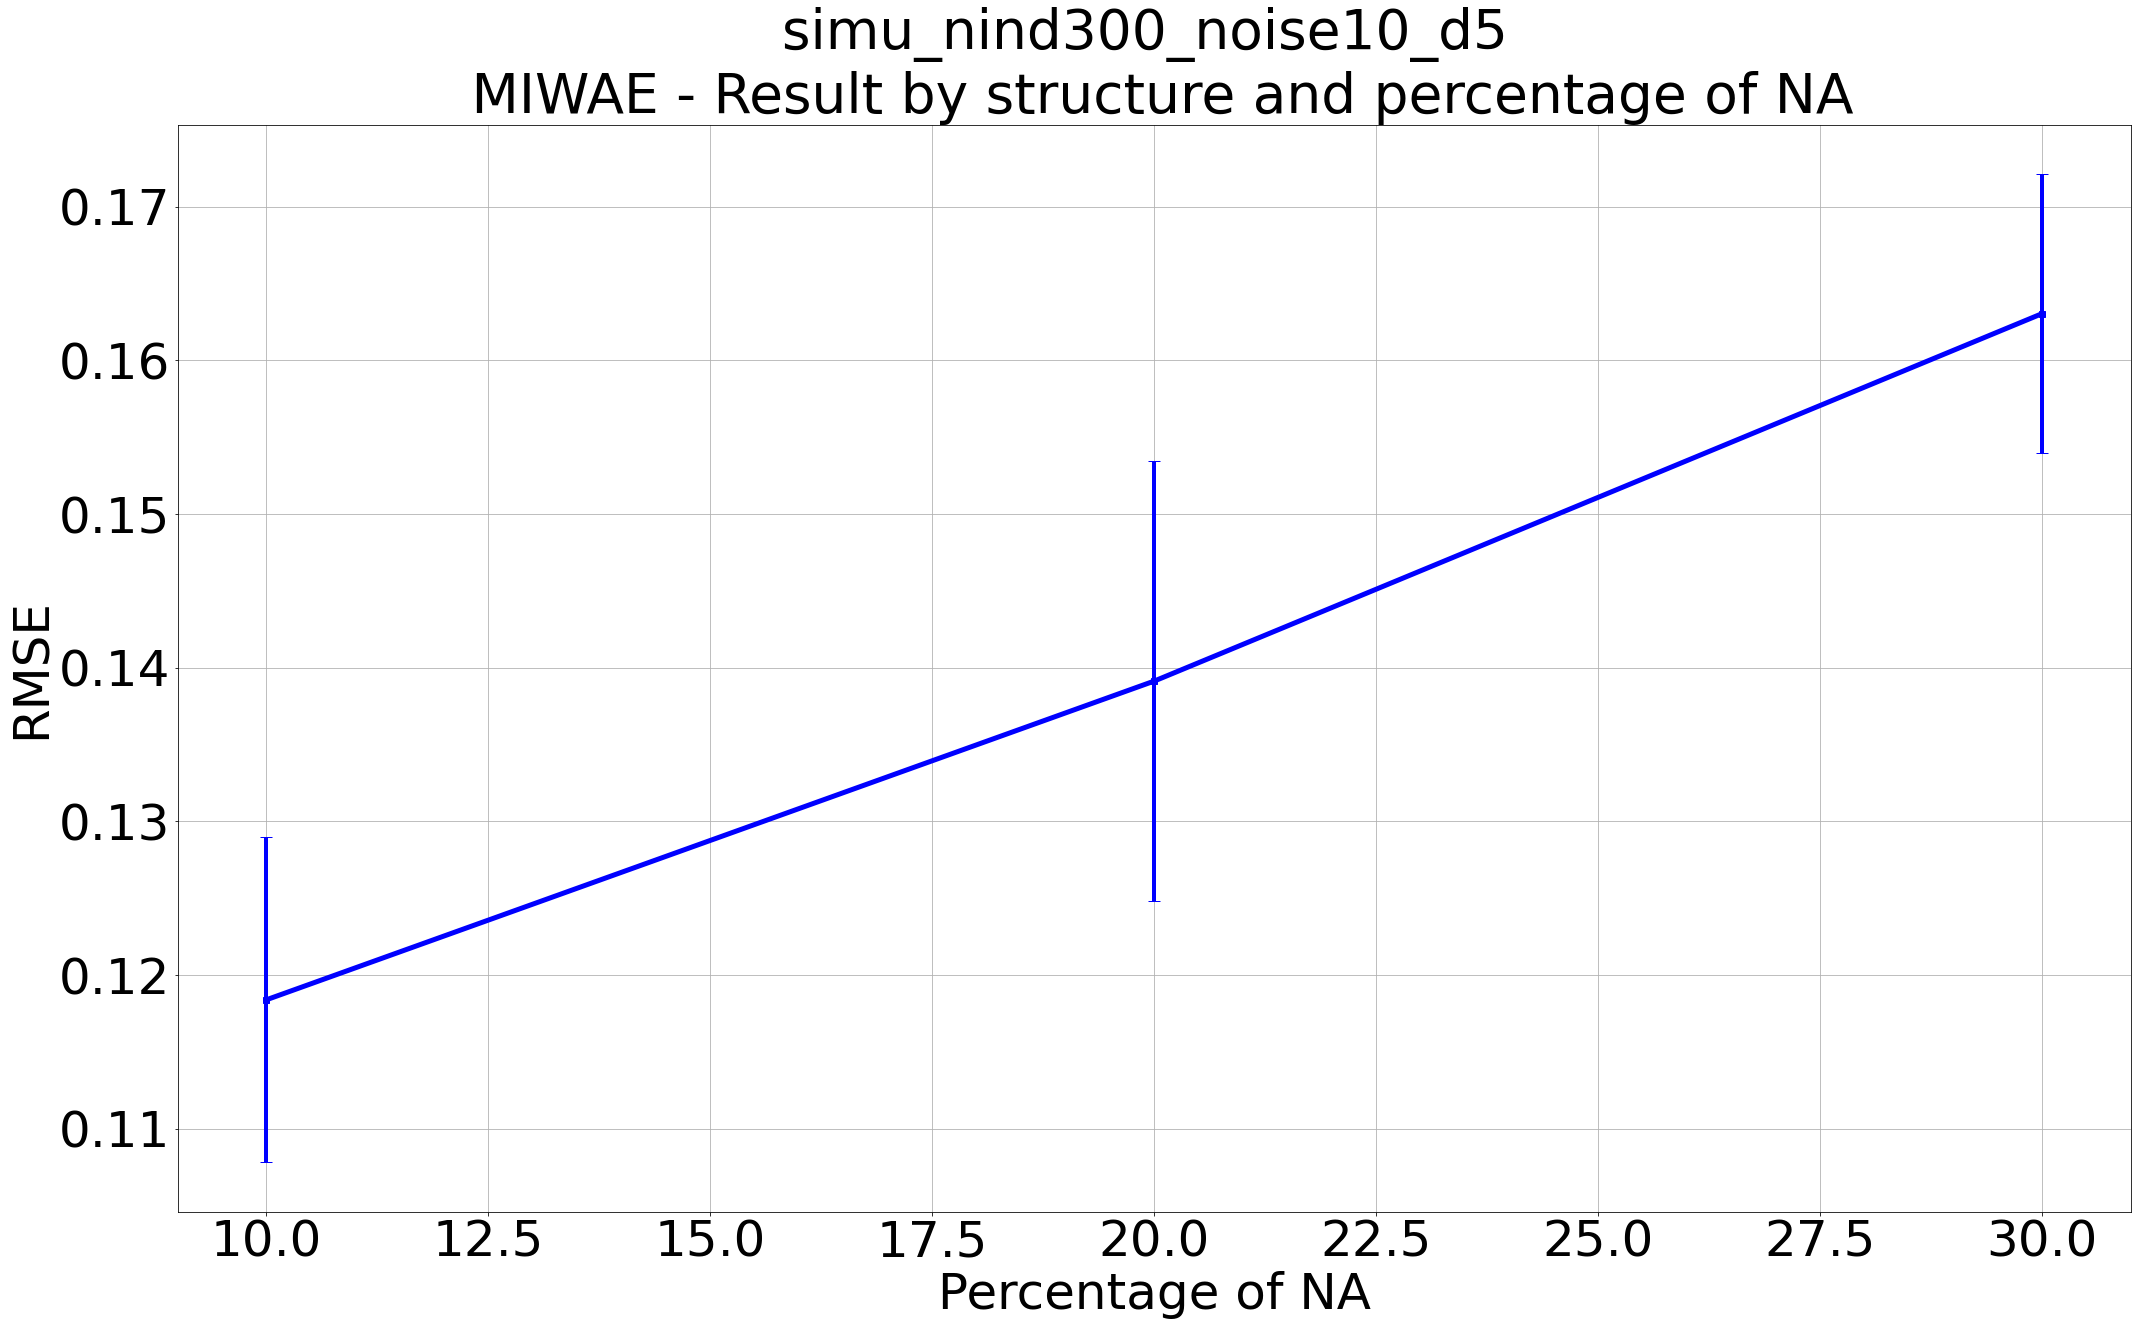

In [23]:
#Parameters

algo = 'MIWAE'
nom_fichier = 'Results_{0}.csv'.format(nom_data)

#Import results
res = pd.read_csv(path + nom_fichier, sep=';')
data = res[res['Algorithm']== algo]
NA = list(data['Percent_NA'].unique())
layers = list(data['Layers'].unique())

#Synthesis of the results
gp1 = data.groupby(['Algorithm','Layers','Activation','Percent_NA'])
nb_rep_vers = gp1['Version'].agg(['count']).iloc[0].unique()

#Calculate mean et std for the chosen algorithm
res_RMSE = gp1['RMSE'].agg(['mean','std','count'])
res_algo = res_RMSE.loc['{}'.format(algo)]

#Plot the results
c = ['blue','red','green','darkviolet','orange','lightgreen','deeppink','coral','skyblue']
fig, ax = plt.subplots(figsize=(35,20))
if algo != 'MIWAE':
    i = 0

    for k in layers:
        ax.errorbar(NA,
                          res_algo.loc[k,'relu']['mean'],
                          yerr=1.96*res_algo.loc[k,'relu']['std']/np.sqrt(nb_rep_vers), 
                          color = c[i], 
                          label = str(k+' relu'), 
                          marker = 's',
                          capsize = 6,
                          elinewidth = 4,
                          lw = 5)
                    
        eb_tanh = ax.errorbar(NA,
                      res_algo.loc[k,'tanh']['mean'],
                      yerr=1.96*res_algo.loc[k,'tanh']['std']/np.sqrt(nb_rep_vers), 
                      color = c[i], 
                      label = str(k+' tanh'), 
                      marker = 's',
                      capsize = 6,
                      elinewidth = 4, 
                      linestyle = 'dashed',
                      lw = 5 )
        eb_tanh[-1][0].set_linestyle('--')
        i += 1

else: 
    i= 0
    for k in layers:
        ax.errorbar(NA,
                          res_algo.loc[k,'ReLU']['mean'],
                          yerr=1.96*res_algo.loc[k,'ReLU']['std']/np.sqrt(nb_rep_vers), 
                          color = c[i], 
                          label = str(k+' relu'), 
                          marker = 's',
                          capsize = 6,
                          elinewidth = 4,
                          lw = 5)
        i += 1


ax.tick_params(axis='both', which='major', labelsize=50)
ax.set_xlabel('Percentage of NA', fontsize = 50)
ax.set_ylabel('RMSE', fontsize = 50)
#ax.legend(fontsize = 40, loc = 'lower right')
ax.grid(True)
ax.set_title('{1} \n {0} - Result by structure and percentage of NA'.format(algo, nom_data),fontsize = 55)

#Sauvegarde du graphe au format png
fig.savefig(path + 'Results {0} for {1}.png'.format(nom_data,algo))

## Synthetic plot

### Average of RMSE for the best structure for each combination algo/percentage of NA/version

In [24]:
#Parameters
path = path
nom_data = nom_data
nom_fichier = 'Results_{0}.csv'.format(nom_data)

#Import the results
res = pd.read_csv(path + nom_fichier, sep=';')

#Export the results
with open(path + 'Results_'+nom_data+'_best.csv', 'w', newline='') as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(['Algorithm','Percent_NA','Version','Layers','Activation','RMSE'])
    for a in ['mean','RF','PCA']:
        for n in res[res['Algorithm']== a].iloc[:,0:6].values:
            writer.writerow(n)

data = res[res['Algorithm']!= 'mean']
data = data[data['Algorithm']!= 'RF']
data = data[data['Algorithm']!= 'PCA']

NA, Versions, Algos = list(data['Percent_NA'].unique()), list(data['Version'].unique()), list(data['Algorithm'].unique())

#Calculate the mean and sd for each combination of algo/percentage of NA/version/structure/activation function
gp1 = data.groupby(['Algorithm','Percent_NA','Version','Layers','Activation'])
res_RMSE = gp1['RMSE'].agg(['mean','std'])

#Values are ranked by RMSE
res_RMSE = res_RMSE.sort_values(['Algorithm','Percent_NA','Version','mean'],ascending=True)

#Export mean of RMSE moyen for each combination
for algo in Algos:
    for na in NA:
        for vers in Versions:
            interm = res_RMSE.loc[algo,na,vers]['mean']
            struc_acti = list(interm[interm == interm.min()].index[0])
            rmse = res_RMSE.loc[algo,na,vers,struc_acti[0],struc_acti[1]]['mean']
            with open(path + 'Results_' + nom_data + '_best.csv', 'a', newline='') as file:
                writer = csv.writer(file,delimiter=';')
                writer.writerow([algo,na,vers,struc_acti[0],struc_acti[1],rmse])
        

### Best average RMSE for algo/percentage of missing values/version combinations
For each average RMSE is also indicated the 95% confidence interval, hence the need to do at least 2 repetitions to avoid any error in this part.
Note: In order to take into account the PCA, you have to execute the associated R code and copy the results at the end of the 'Results_' + nom_data + _'_ _best.csv' obtained previously.

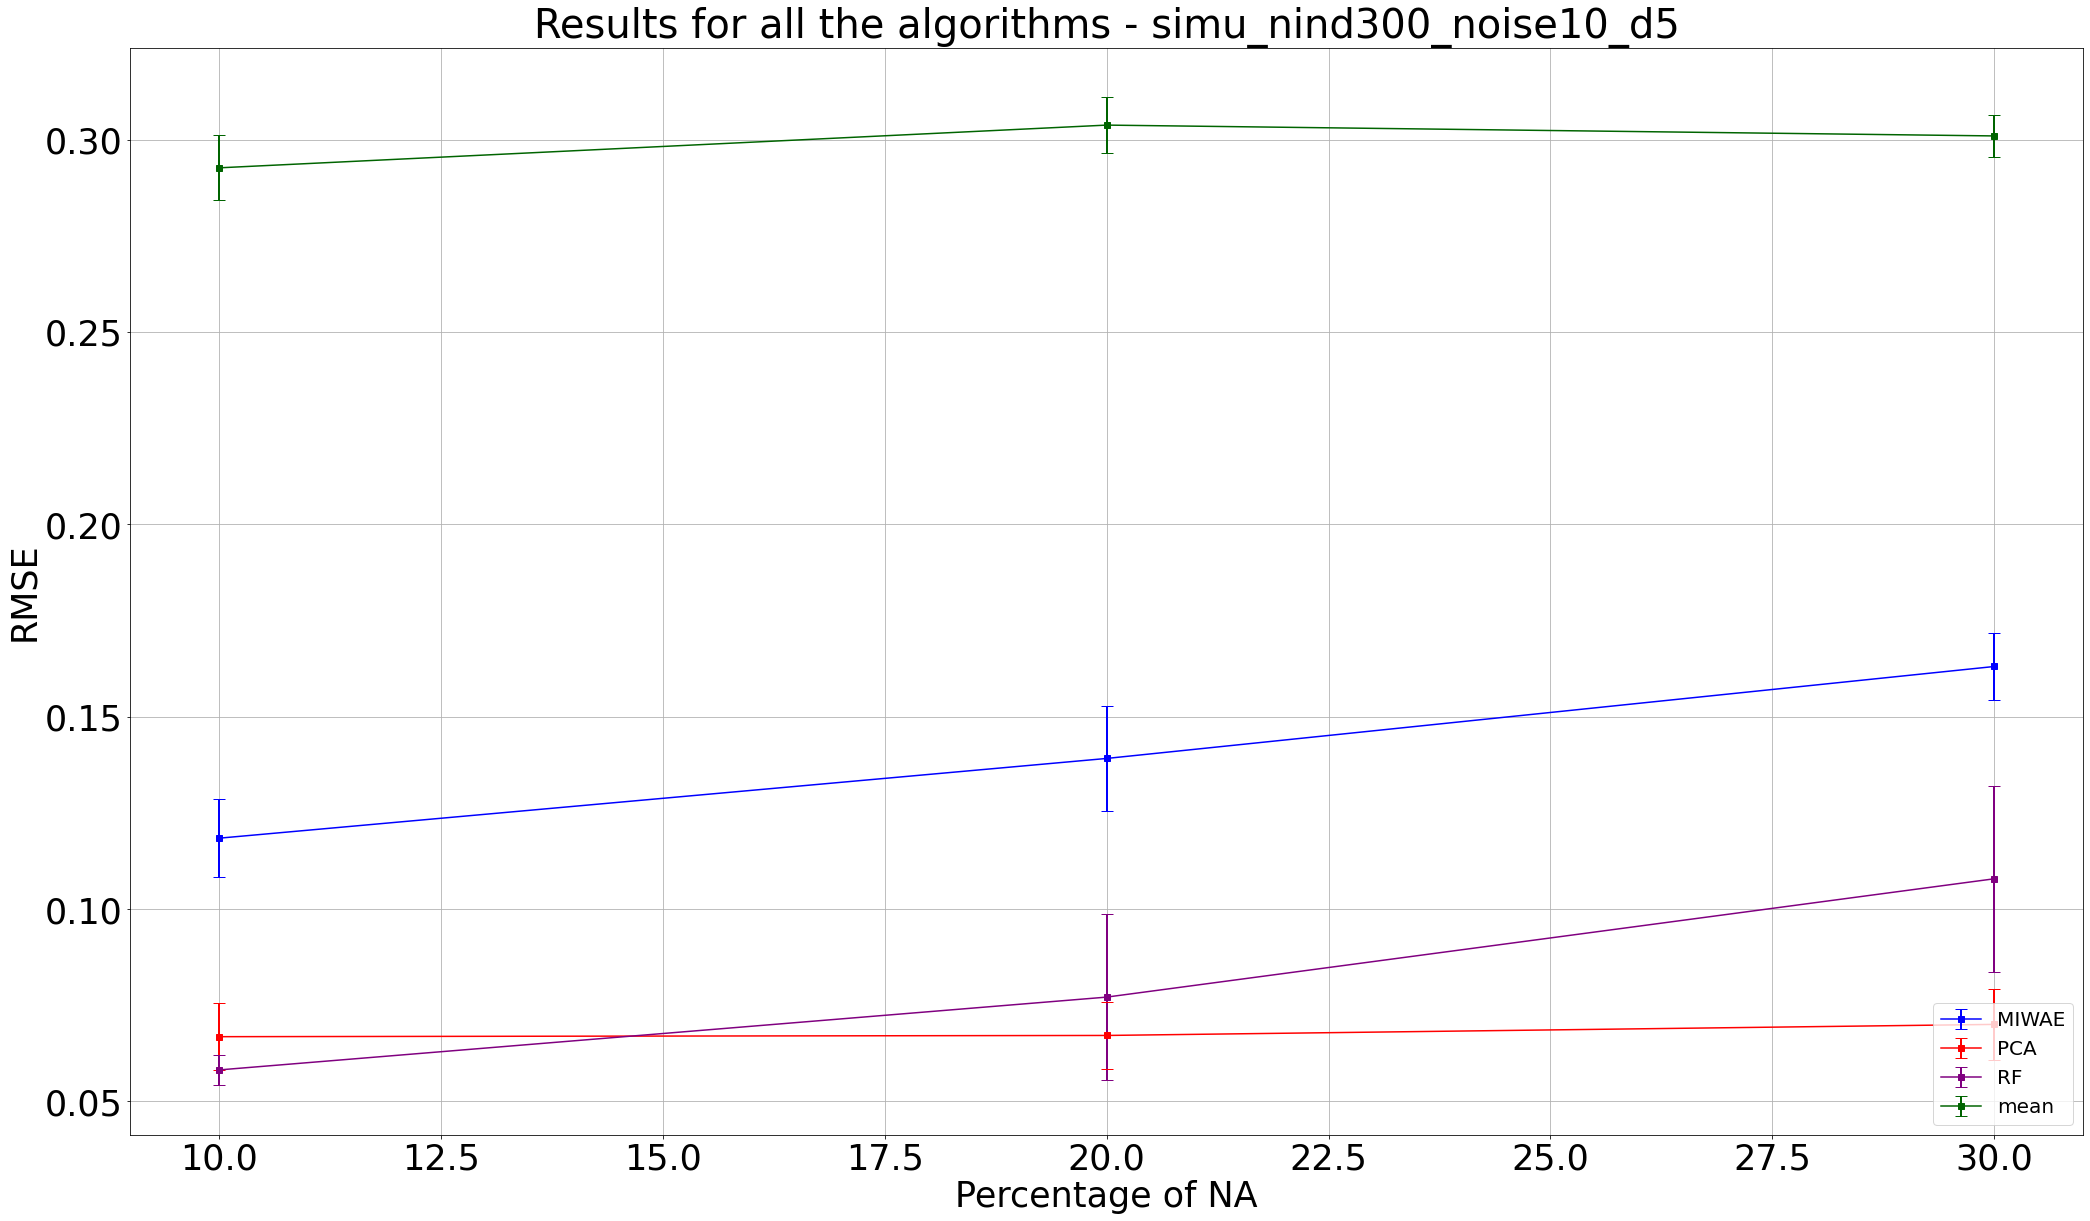

In [25]:
#Import results
data = pd.read_csv(path + 'Results_' + nom_data + '_best.csv', sep=';')

NA = data.iloc[:,1].unique()
vers = len(data.iloc[:,2].unique())

#Synthesis of the results : calculale mean and sd of RMSE by algorithm and % of NA
gb = data.groupby(['Algorithm','Percent_NA'])
synth = gb['RMSE'].agg(['mean','std'])

#Export results
synth.to_csv(path + 'Synthesis of the results {}.csv'.format(nom_data), sep = ';')

#Number of algorithms
algos = list(synth.index.get_level_values('Algorithm').unique())

#Plot results
c = ['blue','red','purple','darkgreen','orange','lightpink','k']
fig, ax = plt.subplots(figsize=(35,20))
for k in range(0,len(algos),1):
    if algos[k] != 'MIWAE':
        ax.errorbar(NA,
                    synth.iloc[k*len(NA):(k+1)*len(NA),0],
                    yerr=1.96*synth.iloc[k*len(NA):(k+1)*len(NA),1]/np.sqrt(vers), 
                    color = c[k], 
                    label = algos[k], 
                    marker = 's',
                    capsize = 6,
                    elinewidth = 2)
    else:
        ax.errorbar(NA,
            synth.iloc[k*len(NA):(k+1)*len(NA),0],
            yerr=1.96*synth.iloc[k*len(NA):(k+1)*len(NA),1]/np.sqrt(vers), 
            color = c[k], 
            label = algos[k], 
            marker = 's',
            capsize = 6,
            elinewidth = 2)
    
ax.tick_params(axis='both', which='major', labelsize=35)
ax.set_xlabel('Percentage of NA', fontsize=35)
ax.set_ylabel('RMSE', fontsize=35)
ax.legend(fontsize = 20, loc = 'lower right')
ax.grid(True)
ax.set_title('Results for all the algorithms - {}'.format(nom_data),fontsize = 40)

#Sauvegarde de la figure dans le dossier 
fig.savefig(path + '{}Results for all the algorithms.png'.format(nom_data))
